In [7]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [8]:
def df_gen(RESULTS_DIR, NSHARDS):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [9]:
def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)


    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.ylim(0,1)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)

In [66]:
def compute_and_plot_graph_metric_correlations(
    df: pd.DataFrame,
    graph_metrics: list,
    models: list,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (10, 8)
):
    """
    1) Filters df to rows where 'feature_dim' == feature_dim.
    2) For each graph‐metric in graph_metrics, compute its correlation (Pearson or Spearman)
       against each model’s performance column: f"{model}__{perf_suffix}".
    3) Plots the resulting correlation matrix as a heatmap.

    Args:
      df:            The full DataFrame containing your results and graph_metrics.
      graph_metrics: List of column‐names (strings) that describe graph‐level metrics.
      models:        List of model‐prefixes, e.g. ['MLP','GCN','HGCN'].
      perf_suffix:   The suffix of the performance column, e.g. "test_f1_macro".
      corr_method:   "pearson" or "spearman".
      figsize:       Size of the final figure.
    Returns:
      corr_df:       A DataFrame of shape (len(graph_metrics) × len(models)), containing
                     correlation coefficients.
    """

    df16 = df

    # 2) Build an empty DataFrame to hold correlation coefficients
    corr_df = pd.DataFrame(
        index=graph_metrics,
        columns=models,
        dtype=float
    )

    # 3) For each model, for each graph_metric, compute correlation w.r.t. performance
    for model in models:
        perf_col = f"{model}__{perf_suffix}"
        if perf_col not in df16.columns:
            raise KeyError(f"Performance column {perf_col} not found in DataFrame.")

        # We’ll drop NaNs pairwise
        for metric in graph_metrics:
            if metric not in df16.columns:
                raise KeyError(f"Graph‐metric column {metric} not found in DataFrame.")
            sub = df16[[metric, perf_col]].dropna()

            # Now drop any rows where either value is not finite (inf or NaN).
            # (pearsonr / spearmanr require strictly finite inputs.)
            x = sub[metric].values
            y = sub[perf_col].values
            finite_mask = np.isfinite(x) & np.isfinite(y)
            x_finite = x[finite_mask]
            y_finite = y[finite_mask]

            # If fewer than 3 points remain, correlation is not well-defined:
            if x_finite.shape[0] < 3:
                corr_val = np.nan
            else:
                if corr_method == "pearson":
                    corr_val, _ = pearsonr(x_finite, y_finite)
                elif corr_method == "spearman":
                    corr_val, _ = spearmanr(x_finite, y_finite)
                else:
                    raise ValueError("corr_method must be 'pearson' or 'spearman'.")

            corr_df.loc[metric, model] = corr_val

    # 4) Plot a heatmap of those correlation coefficients
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_df.astype(float),
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0.0,
        cbar_kws={"label": f"{corr_method.title()} correlation"}
    )
    plt.title(f"{corr_method.title()} correlations")
    plt.ylabel("Graph‐level metric")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_df

## Generated following "Examining the Effects of Degree Distribution and Homophily in Graph Learning Models" as closely as possible
Same parameter ranges, same training/validation sample size, only SBM, using TPE to hyperparameter search rather than grid search.

In [10]:
NSHARDS = 10
models = ['MLP', 'GCN']
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/sample_gen/'
RESULTS_DIR1 = '../../graph_gen/snellius_gen/sample_gen/1/1'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/sample_gen/2/2'
RESULTS_DIR3 = '../../graph_gen/snellius_gen/sample_gen/3/3'
RESULTS_DIR4 = '../../graph_gen/snellius_gen/sample_gen/4/4'

df = df_gen(RESULTS_DIR, NSHARDS)
df1 = df_gen(RESULTS_DIR1, NSHARDS)
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df3 = df_gen(RESULTS_DIR3, NSHARDS)
df4 = df_gen(RESULTS_DIR4, NSHARDS)

df = pd.concat([df, df1, df2, df3, df4], axis = 0)
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,HGCN__model_c,HGCN__model_dropout,HGCN__model_hidden_channels,HGCN__model_in_channels,HGCN__model_lr,HGCN__model_num_layers,HGCN__model_weight_decay,HGCN__model_out_channels,HGCN__train_epochs,HGCN__train_patience
0,3451,13.668235,1.293989,16,1.0,1,4.403672,5,0.180281,0.349575,...,0.5,0.0,32.0,16.0,0.0005,2.0,0.0010,5.0,200.0,15.0
1,1793,6.976331,1.257445,16,1.0,1,4.173960,9,0.398016,2.280479,...,0.5,0.0,8.0,16.0,0.0020,1.0,0.0001,9.0,200.0,15.0
2,2551,13.913850,1.648365,16,1.0,1,1.307754,5,0.160865,1.309671,...,1.0,0.6,16.0,16.0,0.0005,1.0,0.0001,5.0,200.0,15.0
3,1303,25.040123,1.565226,16,1.0,1,5.858899,2,0.003141,1.520384,...,2.0,0.0,32.0,16.0,0.0020,1.0,0.0010,2.0,200.0,15.0
4,1086,19.685873,1.190628,16,1.0,1,9.198998,4,0.967955,1.646999,...,0.5,0.0,32.0,16.0,0.0010,1.0,0.0010,4.0,200.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1985,16.795986,0.754590,16,1.0,1,5.967239,4,0.606289,1.508523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,4073,15.290829,1.716404,16,1.0,1,14.315954,4,0.244679,1.702518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,3639,10.117695,0.206674,16,1.0,1,1.927958,9,0.544583,1.126989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,1722,11.620669,1.715969,16,1.0,1,6.999645,4,0.643243,2.200171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Testing ideas as they come up

In [84]:
# this colelction was benchmarked with the tuning metric as rocauc_ovr. notice the tighter spread to the lower dataset, that was tunmed towards f1_macro.
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/5/5'
df = df_gen(RESULTS_DIR, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


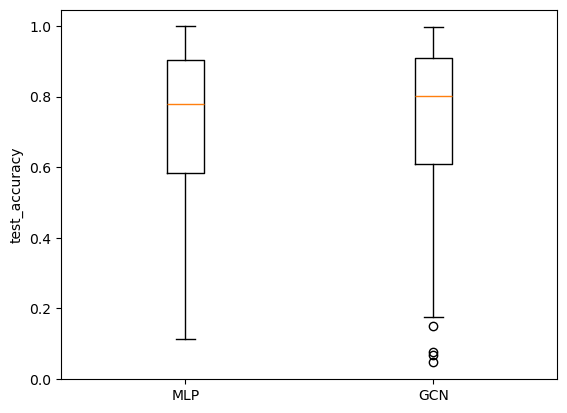

In [85]:
boxplots(df, models, metric = "test_accuracy")


In [79]:
# this colelction was benchmarked in a few-shot setting: one train/val per class.
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/1_train/1_train'
df = df_gen(RESULTS_DIR, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


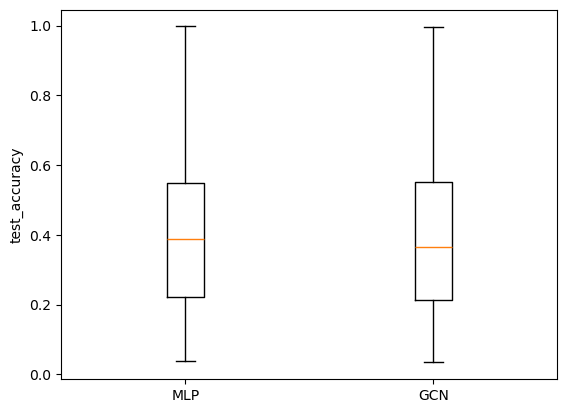

In [83]:
boxplots(df, models, "test_accuracy")

## Back to main thing

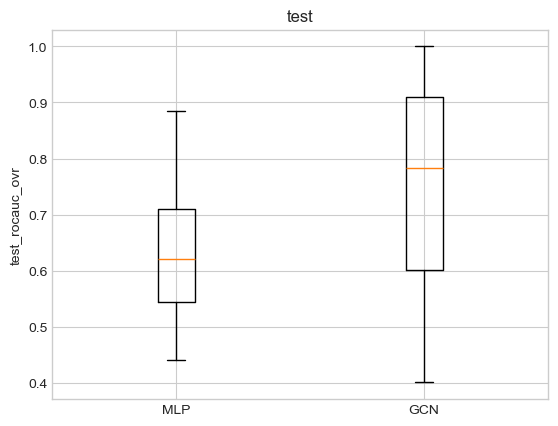

In [135]:
def boxplots(df, models, metric, label = None):
    plt.boxplot(df[[f'{model}__{metric}' for model in models]], tick_labels= ['MLP', 'GCN'], label = label)
    plt.ylabel(f'{metric}')
    plt.title(label)
    plt.show()

boxplots(df, models = ['MLP', 'GCN'], metric = 'test_rocauc_ovr', label = 'test')

In [23]:
df[['GCN__test_rocauc_ovr', 'MLP__test_rocauc_ovr']].describe()

,GCN__test_rocauc_ovr,MLP__test_rocauc_ovr
count,5000.000000,5000.000000
mean,0.868397,0.874876
std,0.145639,0.146041
min,0.044087,0.062610
25%,0.789095,0.794572
50%,0.930677,0.944550
75%,0.981743,0.987504
max,1.000000,1.000000


In [42]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'approximate_diameter', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

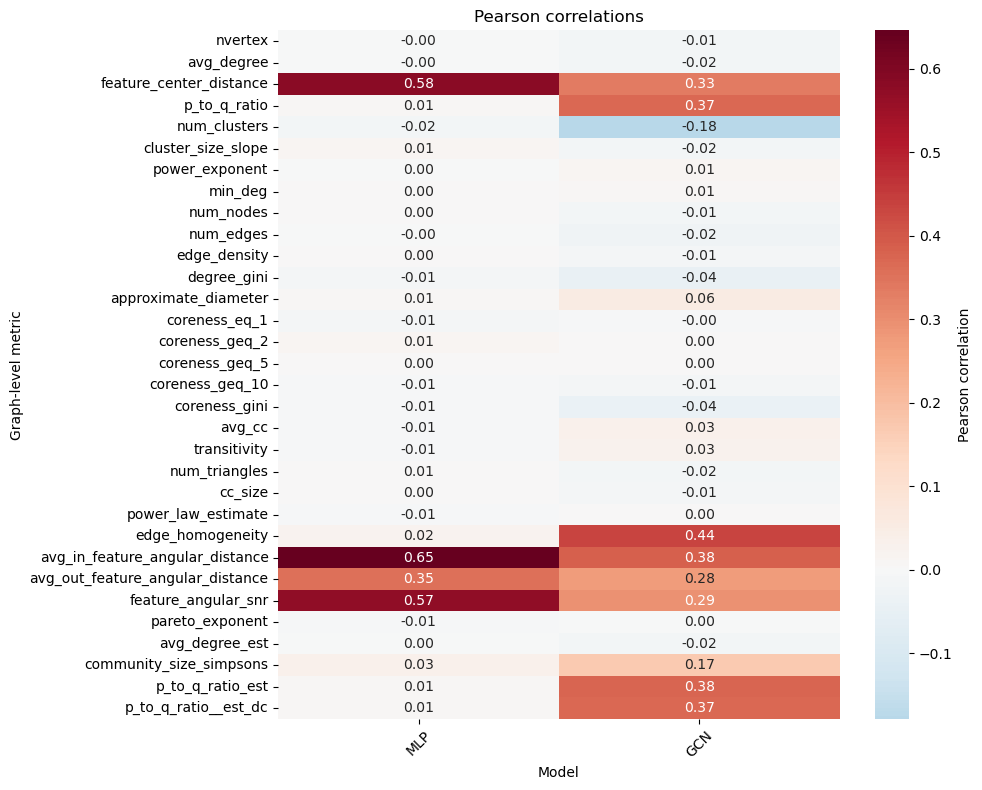

,MLP,GCN
nvertex,-0.000695,-0.014888
avg_degree,-0.000929,-0.019917
feature_center_distance,0.583347,0.334226
p_to_q_ratio,0.006615,0.371627
num_clusters,-0.019753,-0.178447
cluster_size_slope,0.013734,-0.018438
power_exponent,0.000689,0.012369
min_deg,0.004220,0.007832
num_nodes,0.002821,-0.014544
num_edges,-0.004025,-0.024499


In [43]:
compute_and_plot_graph_metric_correlations(df, graph_metrics=graph_metrics, models = models, perf_suffix='test_rocauc_ovr')

<Axes: >

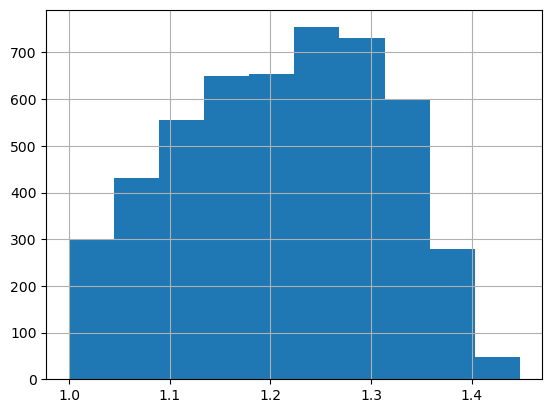

In [47]:
df['feature_angular_snr'].hist()

In [54]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


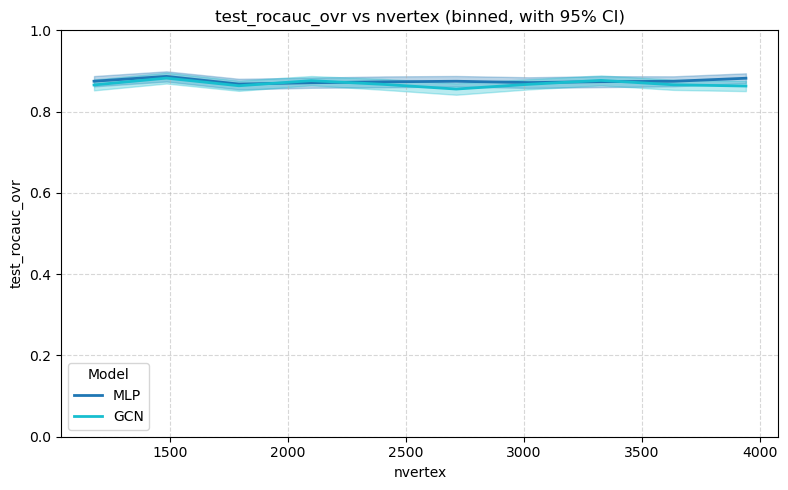

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


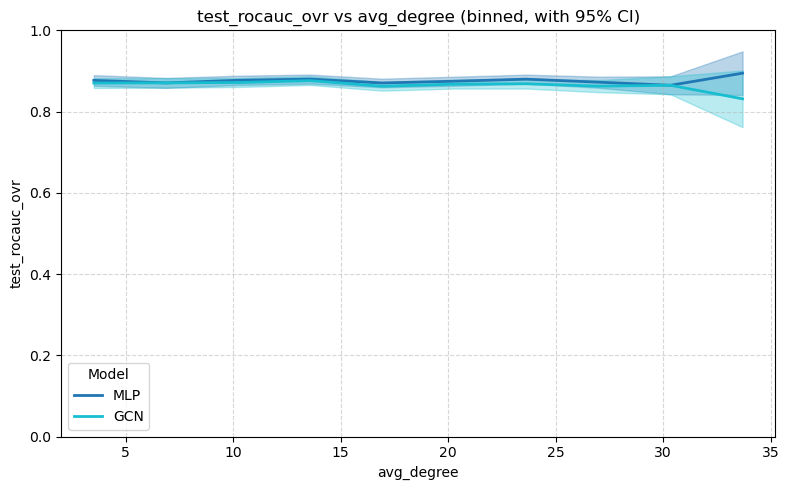

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


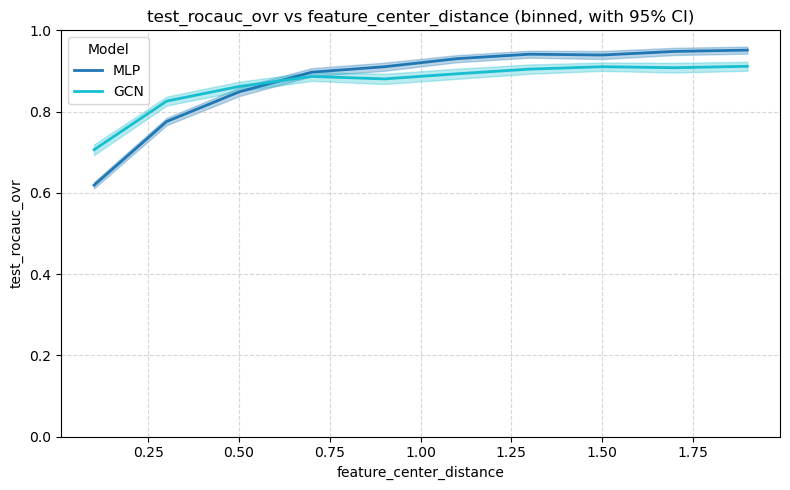

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


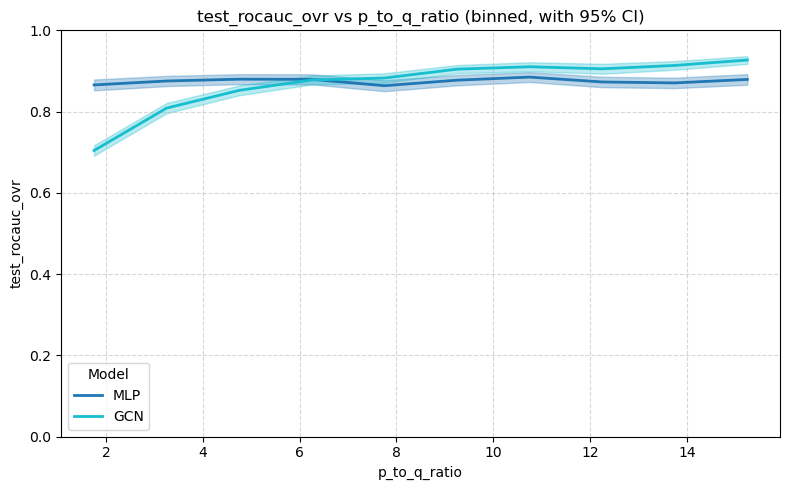

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


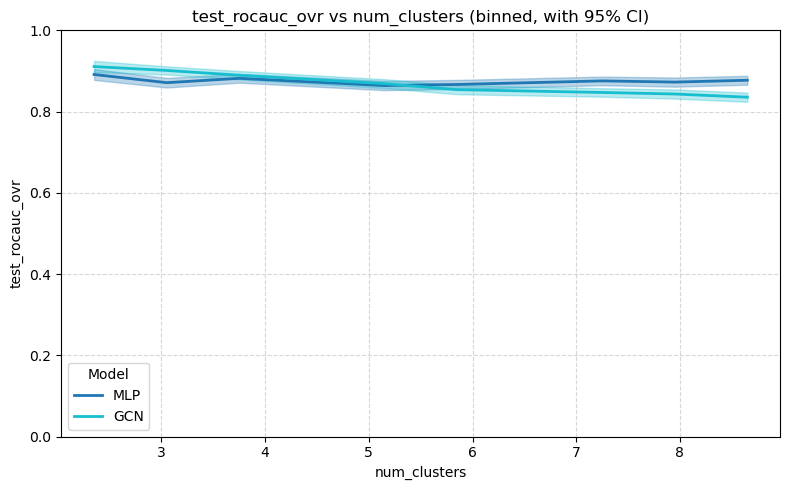

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


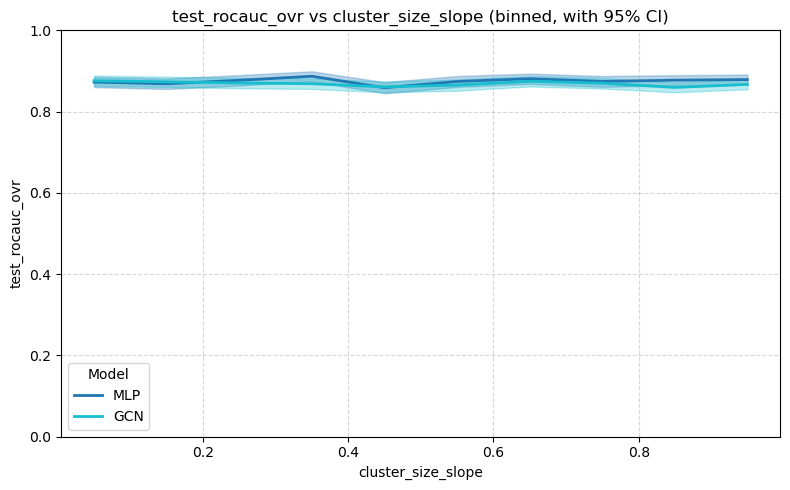

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


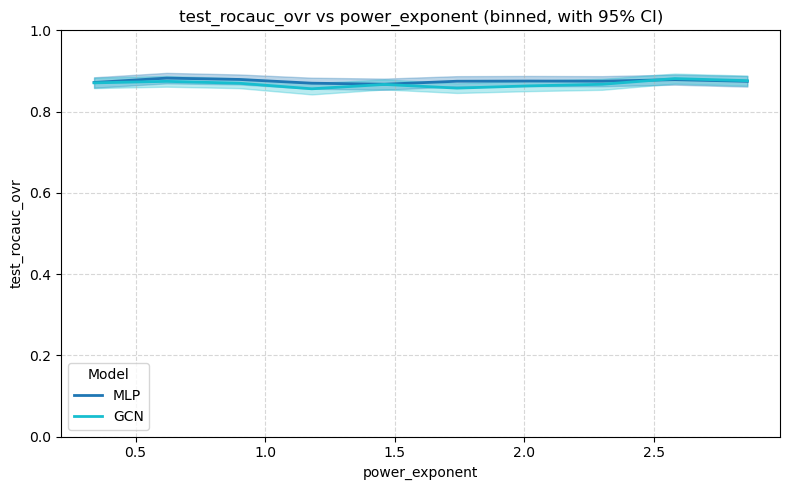

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


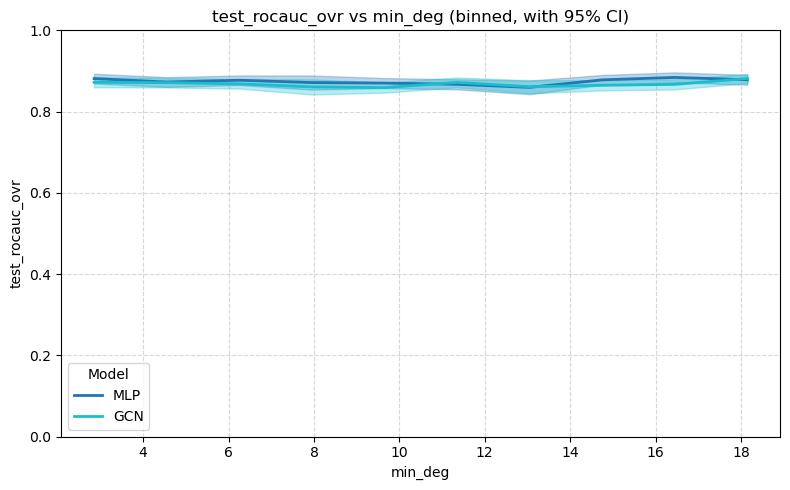

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


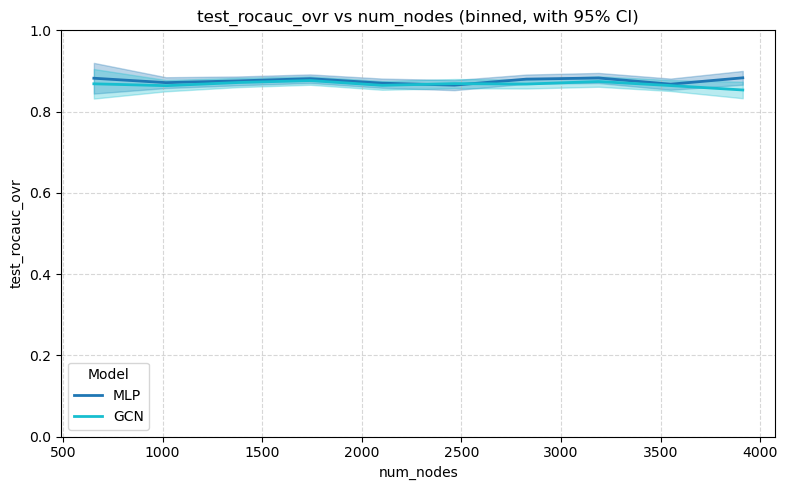

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


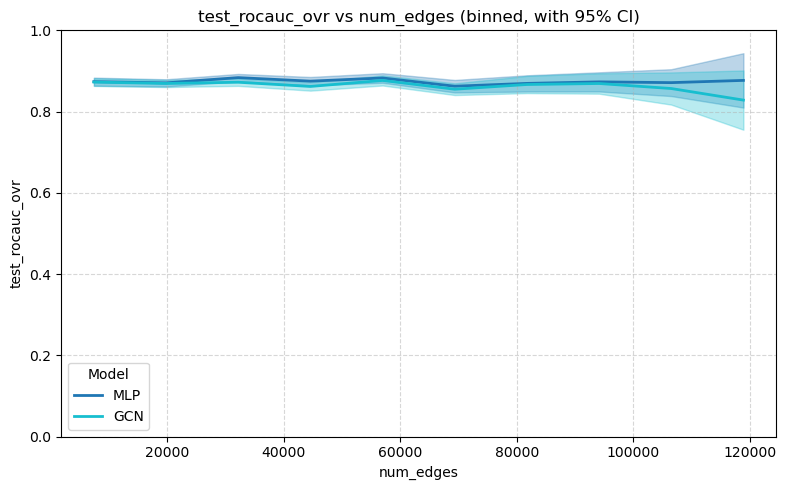

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


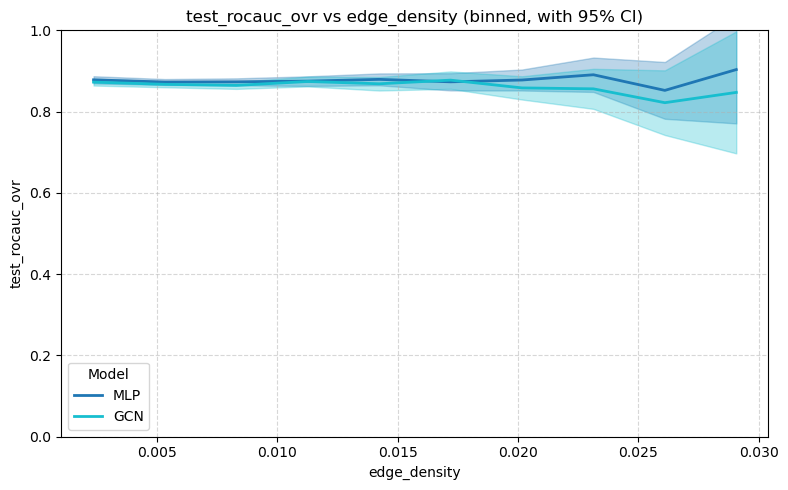

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


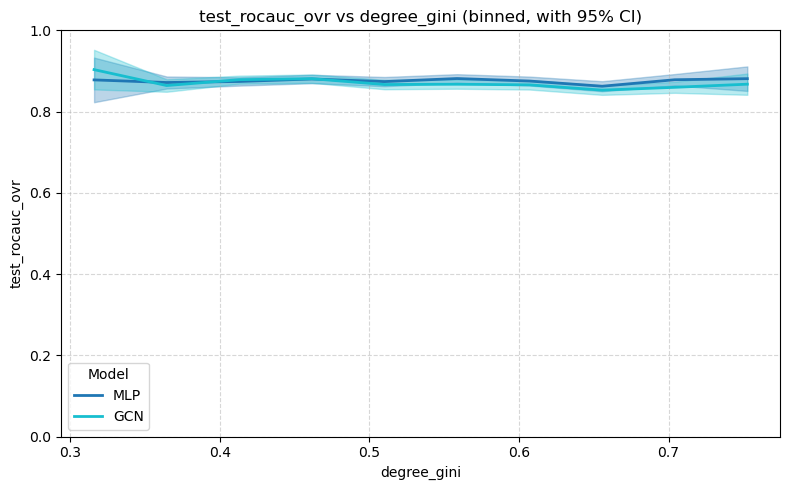

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


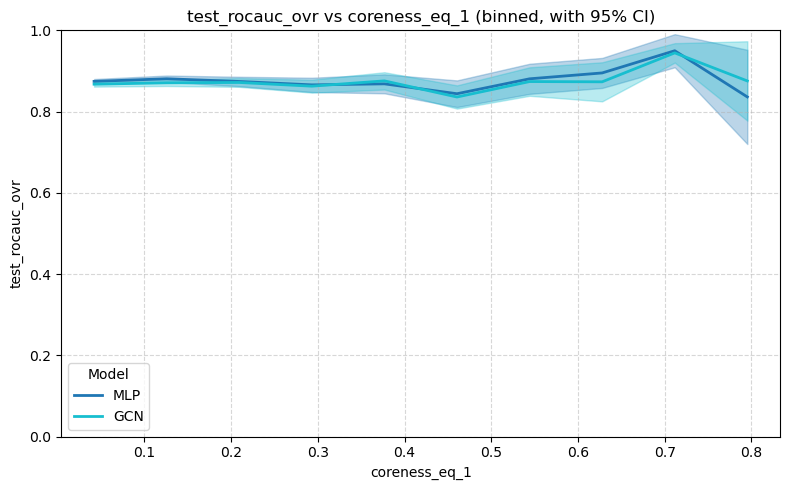

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


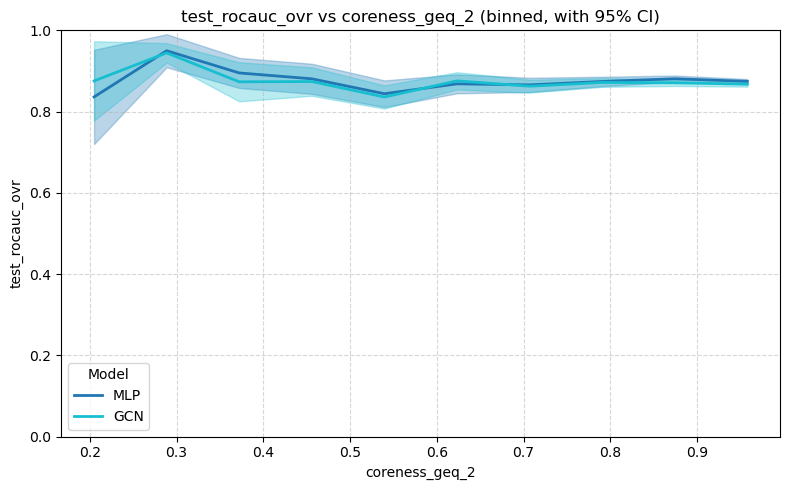

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


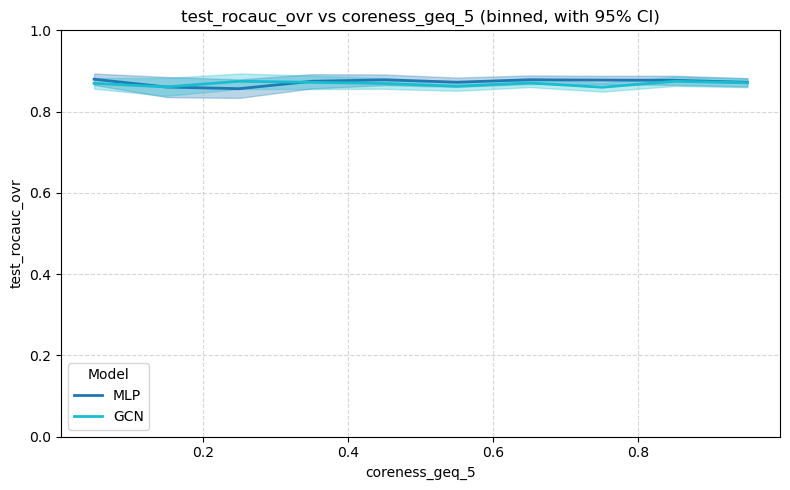

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


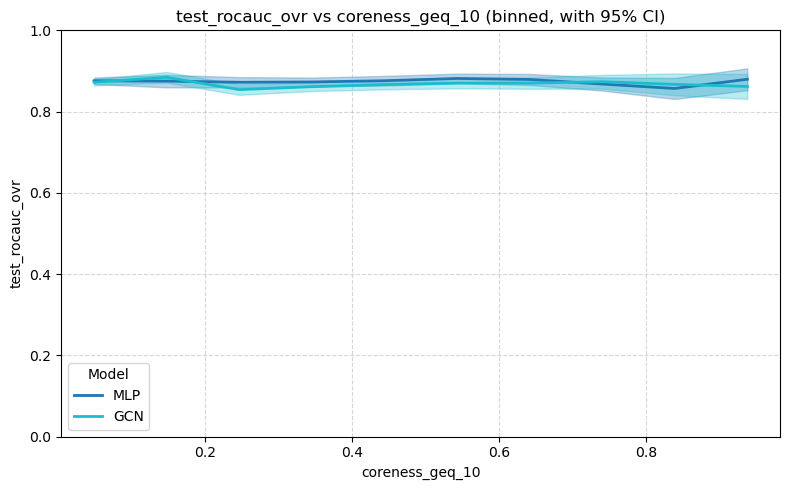

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


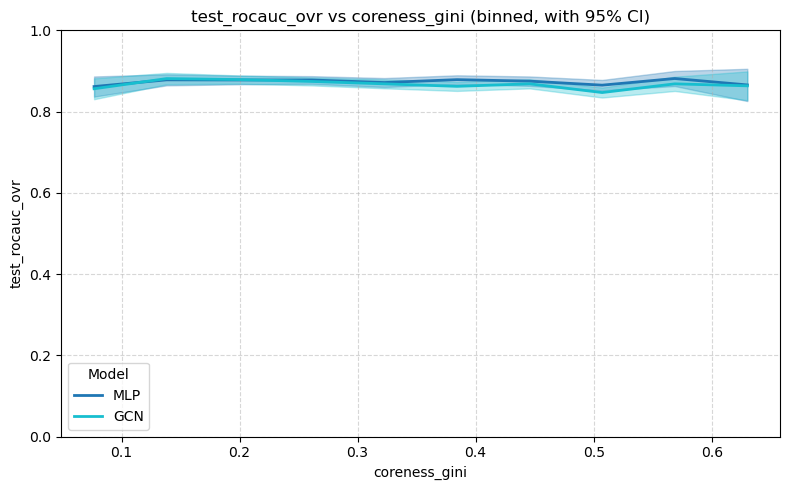

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


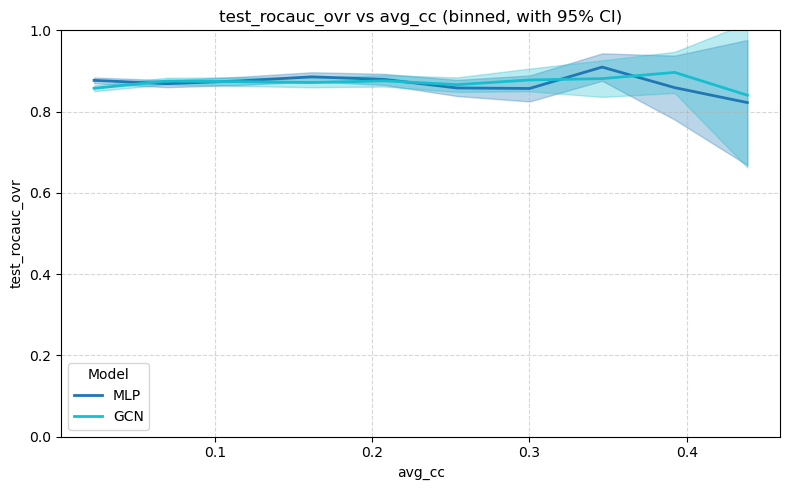

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


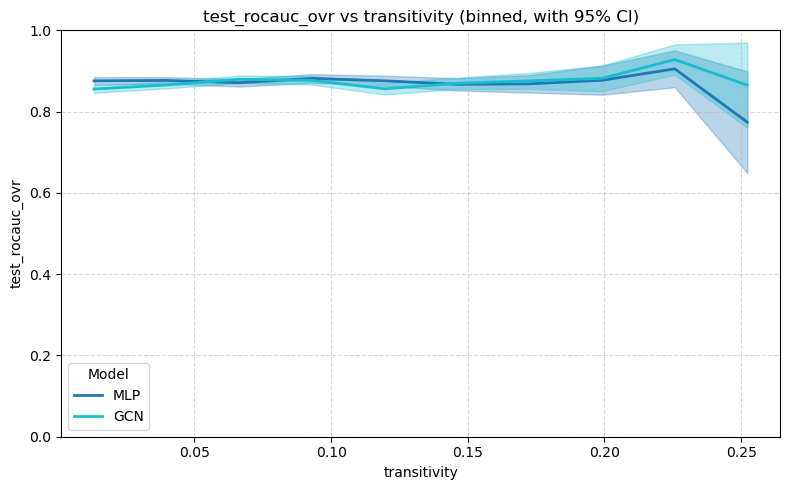

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


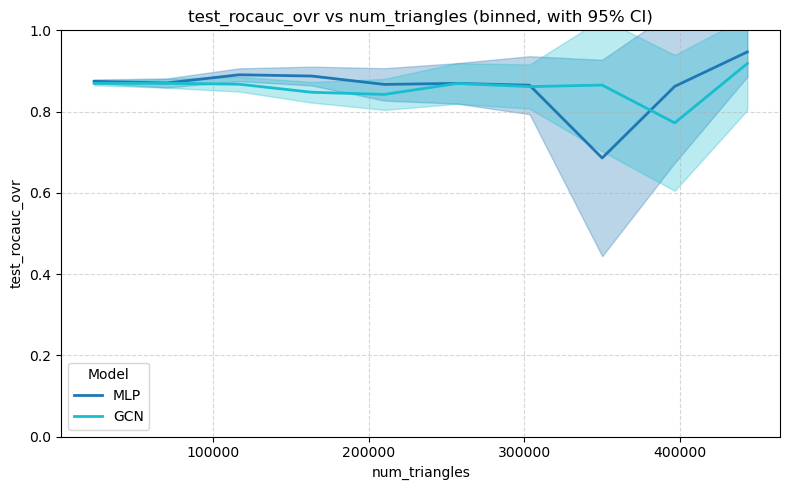

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


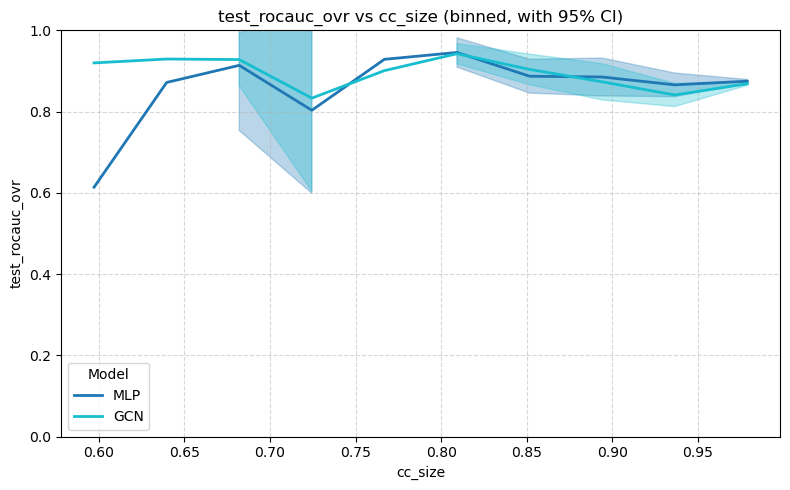

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


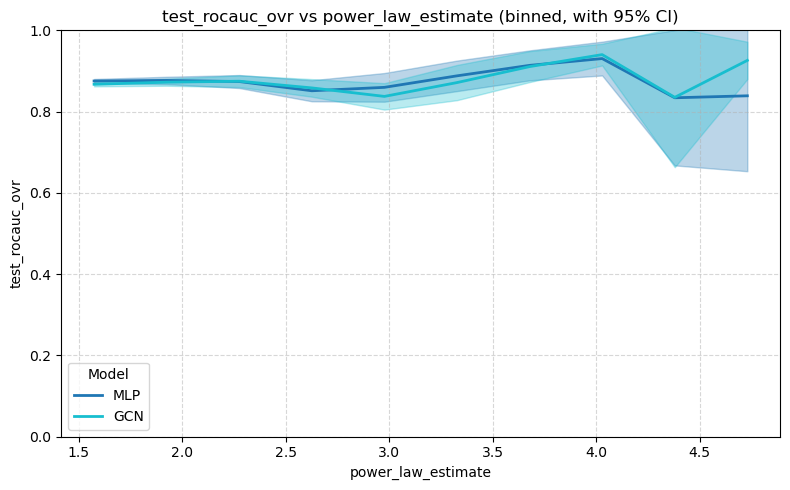

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


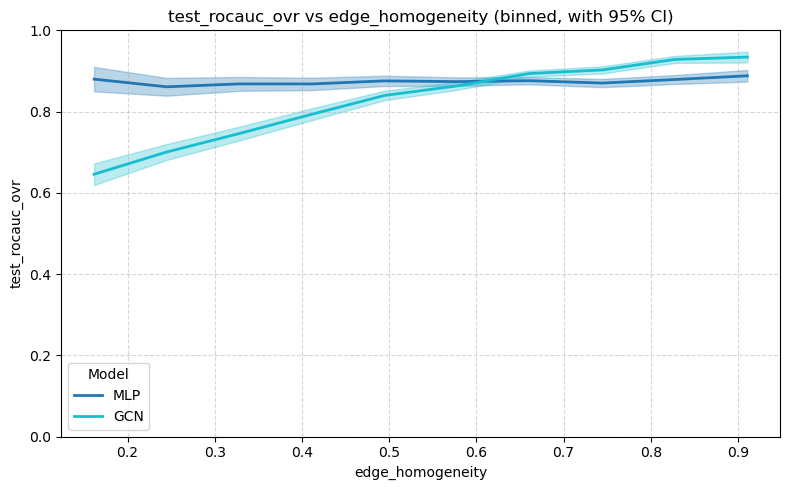

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


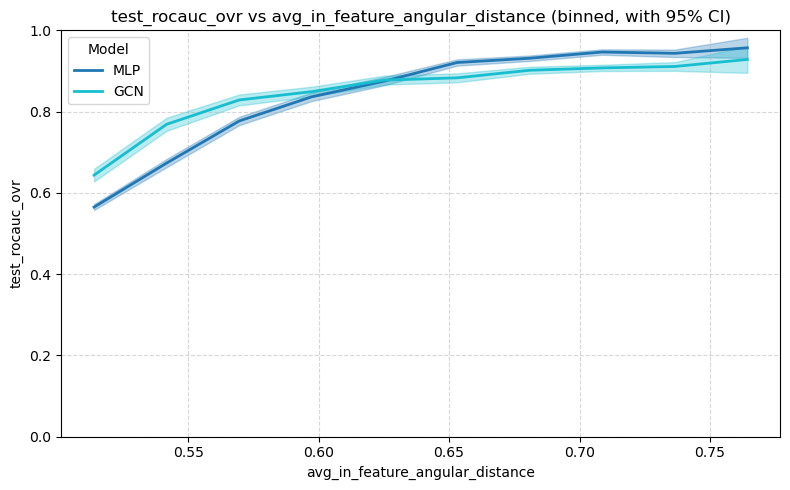

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


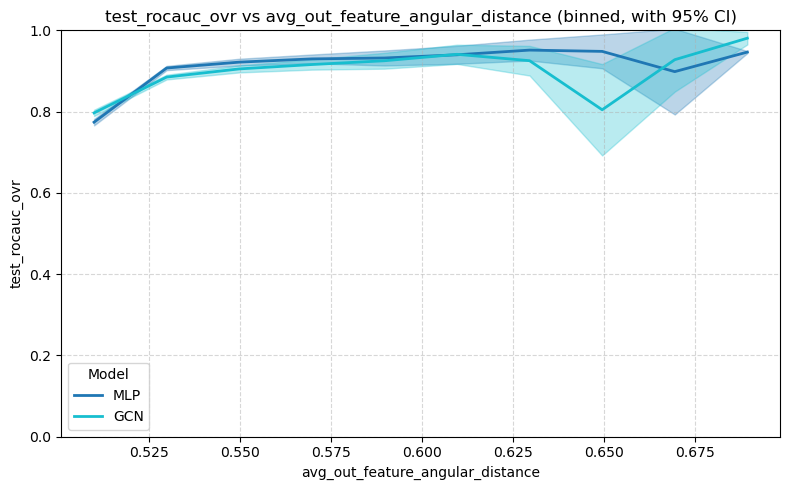

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


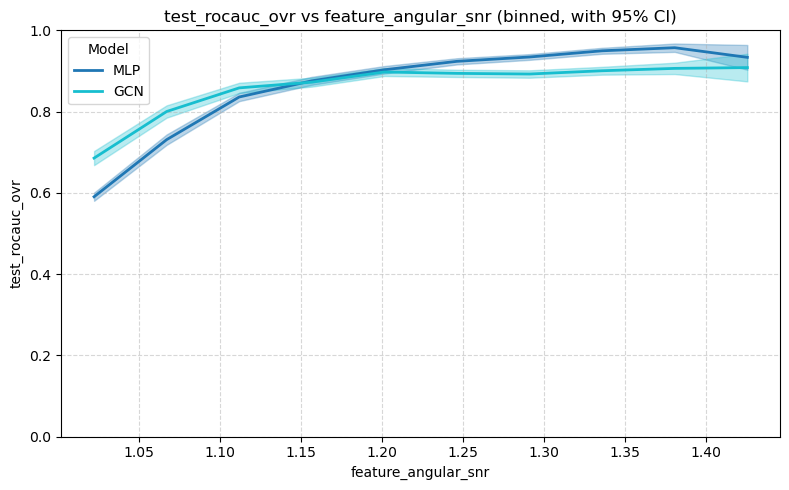

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


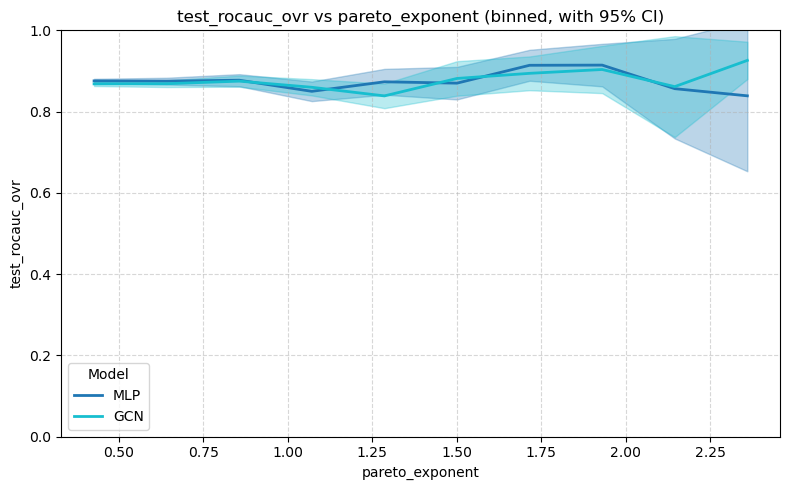

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


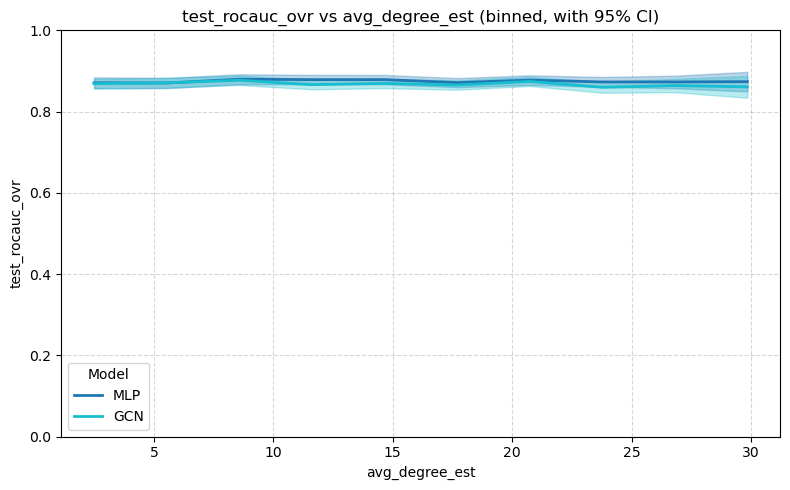

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


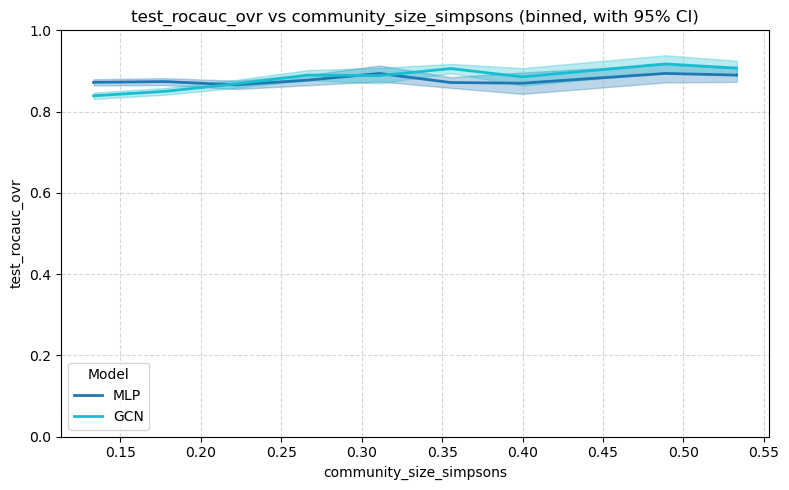

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


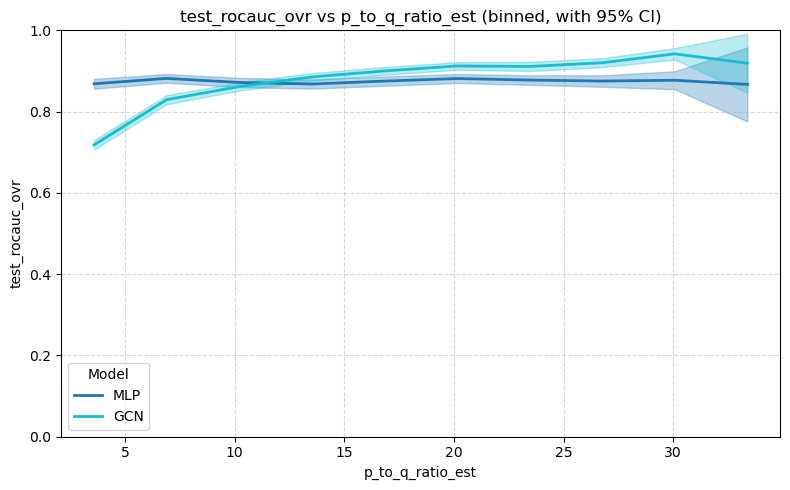

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


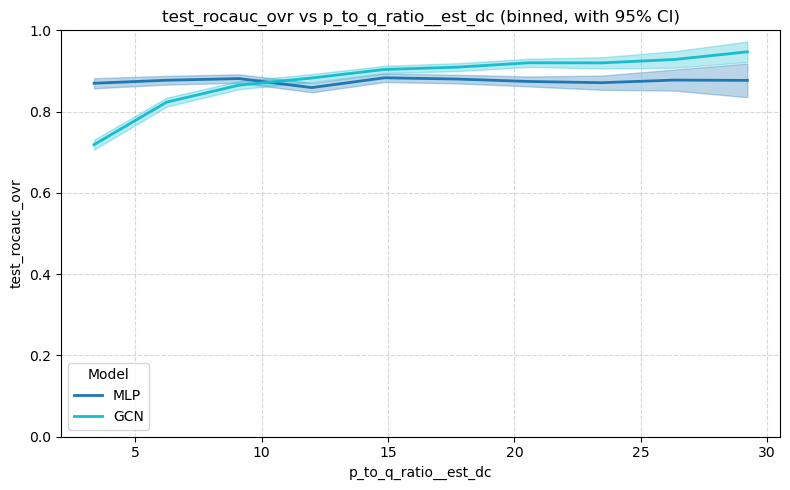

In [56]:
for metric in graph_metrics:
    smoothed_plot_perf_vs_metric(df, models, perf_meas='test_rocauc_ovr', metric=metric, n_bins=10)

In [63]:
metric = 'test_rocauc_ovr'

gcn_col = f"GCN__{metric}"
mlp_col = f"MLP__{metric}"

df['gcn_minus_mlp'] = df[gcn_col] - df[mlp_col]
df['gcn_beats_mlp'] = (df['gcn_minus_mlp'] > 0).astype(int)

print("\n==== Overall performance comparison (paired) ====\n")
t_stat, t_p = ttest_rel(df[gcn_col], df[mlp_col])
w_stat, w_p = wilcoxon(df[gcn_col], df[mlp_col])
print(f"Paired t‑test   : t={t_stat:8.3f}, p={t_p:.3g}")
print(f"Wilcoxon signed‑rank: W={w_stat:8.3f}, p={w_p:.3g}\n")


==== Overall performance comparison (paired) ====

Paired t‑test   : t=  -2.698, p=0.00699
Wilcoxon signed‑rank: W=5997442.000, p=0.0147



In [21]:
hard = df[(df['p_to_q_ratio'] < 2) & (df['feature_center_distance'] < 1.0)]

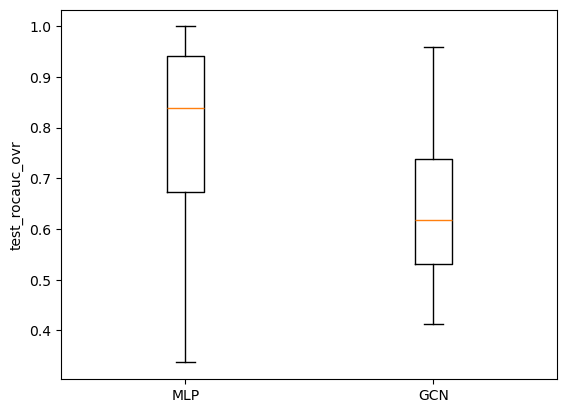

In [22]:
boxplots(hard, models, "test_rocauc_ovr")

## ablations on noise feature dim

In [133]:
# now unnormalized gaussian noise
RESULTS_DIR16 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/noise_dim/noise_dim/2'
RESULTS_DIR4 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/noise_dim/noise_dim/4'
RESULTS_DIR0 = '../../graph_gen/snellius_gen/sample_gen/sample_gen'
df16 = df_gen(RESULTS_DIR16, NSHARDS)
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df4 = df_gen(RESULTS_DIR4, NSHARDS)
df0 = df_gen(RESULTS_DIR0, NSHARDS)


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/2520084578.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


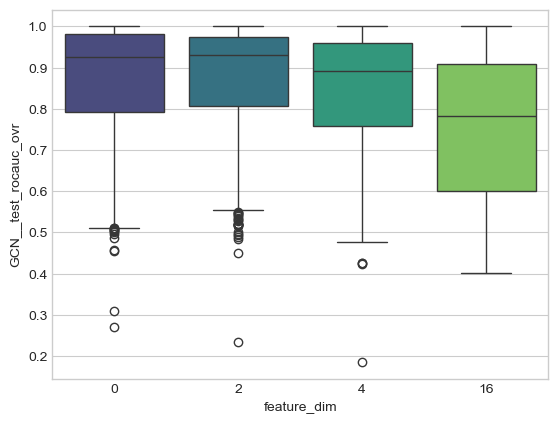

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/2520084578.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


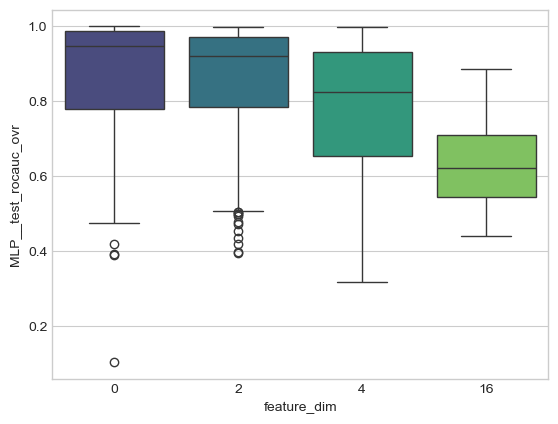

In [134]:
metric = 'test_rocauc_ovr'
dfs = [df0, df2, df4, df16]
noise_feature_dims = [0,2,4,16]

plot_data = []

for i, df in enumerate(dfs):
    df_copy = df[[f'{model}__{metric}' for model in models]].copy()

    df_copy['feature_dim'] = noise_feature_dims[i]
    plot_data.append(df_copy)

combined_df = pd.concat(plot_data, ignore_index=True)

plt.style.use('seaborn-v0_8-whitegrid') # Set a nice style for the plot

for model in ['GCN', 'MLP']:
    sns.boxplot(
        x='feature_dim',
        y=model + '__' + metric,
        data=combined_df,
        palette='viridis' # Use a color palette
    )
    plt.show()

## New dataset - 5000 samples, signal+noise features

In [57]:
NSHARDS = 10
models = ['MLP', 'GCN']
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm'
RESULTS_DIR1 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/1'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/2'
RESULTS_DIR3 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/3'
RESULTS_DIR4 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/4'
RESULTS_DIR5 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/5'

df = df_gen(RESULTS_DIR, NSHARDS)
df1 = df_gen(RESULTS_DIR1, NSHARDS)
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df3 = df_gen(RESULTS_DIR3, NSHARDS)
df4 = df_gen(RESULTS_DIR4, NSHARDS)
df5 = df_gen(RESULTS_DIR5, NSHARDS)


df = pd.concat([df, df1, df2, df3, df4, df5], axis = 0)
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,MLP__test_logloss,MLP__model_dropout,MLP__model_hidden_channels,MLP__model_in_channels,MLP__model_lr,MLP__model_num_layers,MLP__model_weight_decay,MLP__model_out_channels,MLP__train_epochs,MLP__train_patience
0,1352,9.562289,0.390386,16,1.0,1,13.464975,7,0.588315,0.607698,...,1.915104,0.6,16,32,0.0010,1,0.0001,7,200,15
1,1359,13.115789,1.715084,16,1.0,1,14.082951,7,0.333200,1.771090,...,1.759299,0.4,32,32,0.0020,2,0.0005,7,200,15
2,3530,4.380339,0.683335,16,1.0,1,12.749049,8,0.792320,1.960316,...,2.054621,0.4,16,32,0.0020,1,0.0001,8,200,15
3,3551,18.522669,0.491903,16,1.0,1,4.927547,7,0.447886,2.618927,...,1.900633,0.6,32,32,0.0005,1,0.0000,7,200,15
4,2919,16.854589,0.967202,16,1.0,1,14.667087,7,0.185181,2.227018,...,1.795015,0.4,16,32,0.0010,1,0.0010,7,200,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3609,8.031199,0.284539,16,1.0,1,6.456280,2,0.305609,0.407720,...,0.690681,0.4,16,32,0.0020,2,0.0000,2,200,15
4996,1056,13.282520,0.176616,16,1.0,1,2.358084,7,0.430003,0.751247,...,1.932516,0.2,8,32,0.0005,3,0.0005,7,200,15
4997,3578,7.994299,1.955615,16,1.0,1,9.699010,8,0.229193,0.995935,...,2.082255,0.6,16,32,0.0020,3,0.0001,8,200,15
4998,1191,13.736746,0.603972,16,1.0,1,14.052332,9,0.507515,0.841346,...,2.150609,0.6,32,32,0.0020,2,0.0005,9,200,15


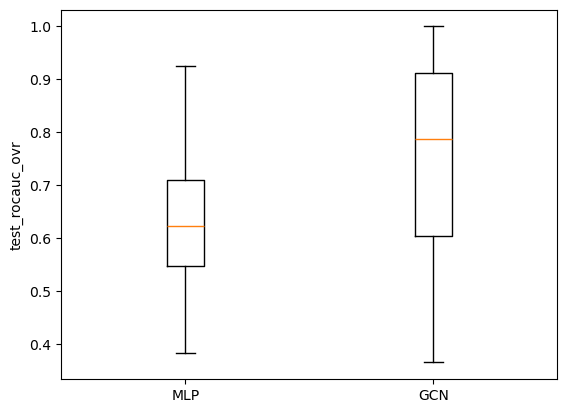

In [58]:
boxplots(df, models, "test_rocauc_ovr")

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


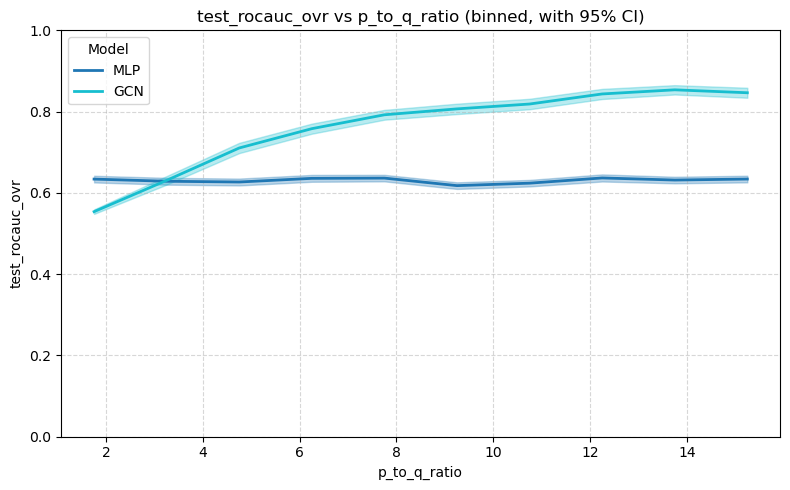

In [60]:
smoothed_plot_perf_vs_metric(df, models, "test_rocauc_ovr", "p_to_q_ratio")

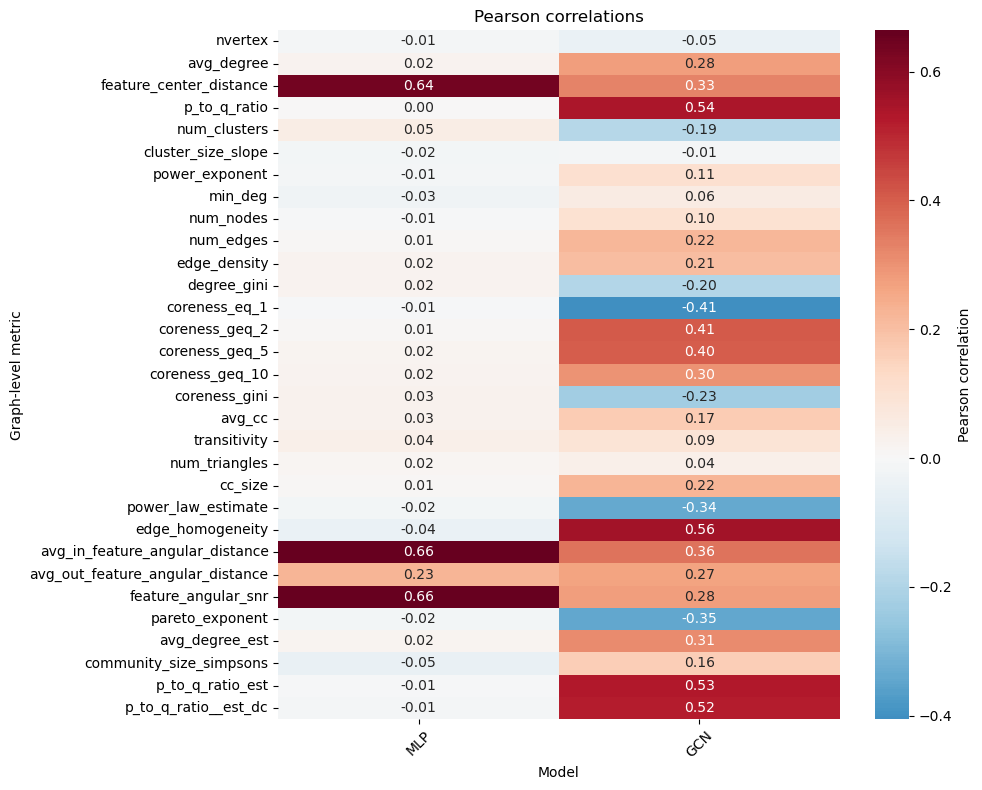

,MLP,GCN
nvertex,-0.010831,-0.045667
avg_degree,0.023543,0.276147
feature_center_distance,0.639768,0.328603
p_to_q_ratio,0.000507,0.541023
num_clusters,0.047858,-0.191718
cluster_size_slope,-0.017199,-0.014026
power_exponent,-0.010666,0.105122
min_deg,-0.028730,0.058090
num_nodes,-0.008336,0.102658
num_edges,0.011789,0.219486


In [ ]:
perf_meas = "test_rocauc_ovr"
df['perf_delta'] = df[f'GCN__{perf_meas}']-df[f'MLP__{perf_meas}']

graph_metrics_refined = ['nvertex', 'num_edges', 'avg_degree', 'degree_gini', 'power_law_estimate', 'p_to_q_ratio',
                 'num_clusters', 'community_size_simpsons', 'edge_homogeneity', 'feature_center_distance',
                 'avg_cc']

graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

compute_and_plot_graph_metric_correlations(df, graph_metrics=graph_metrics, models=models, perf_suffix=perf_meas)

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


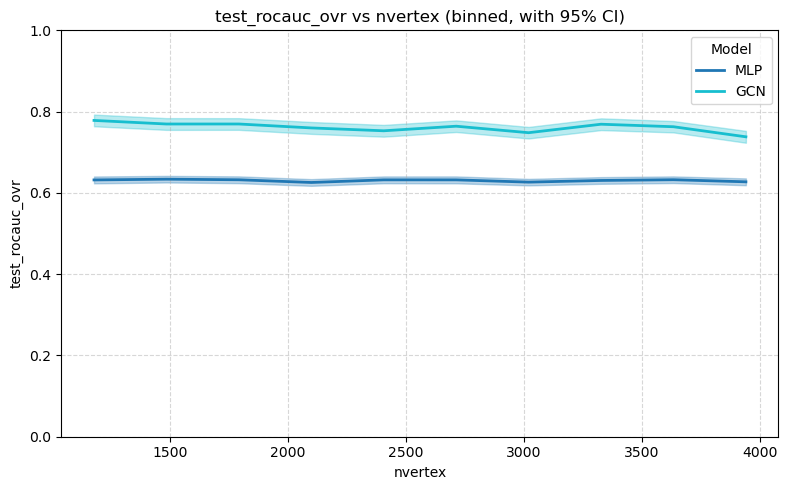

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


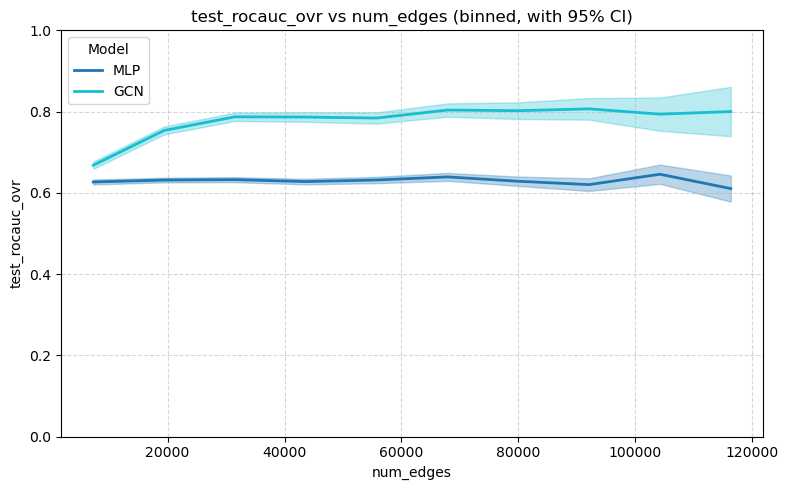

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


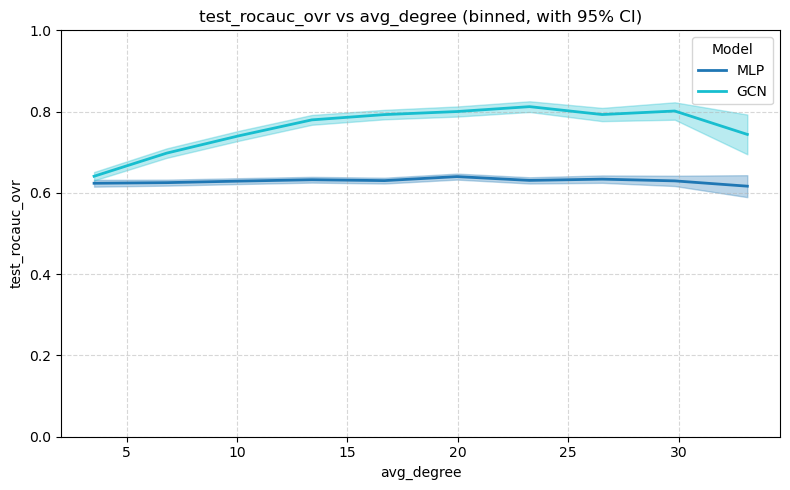

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


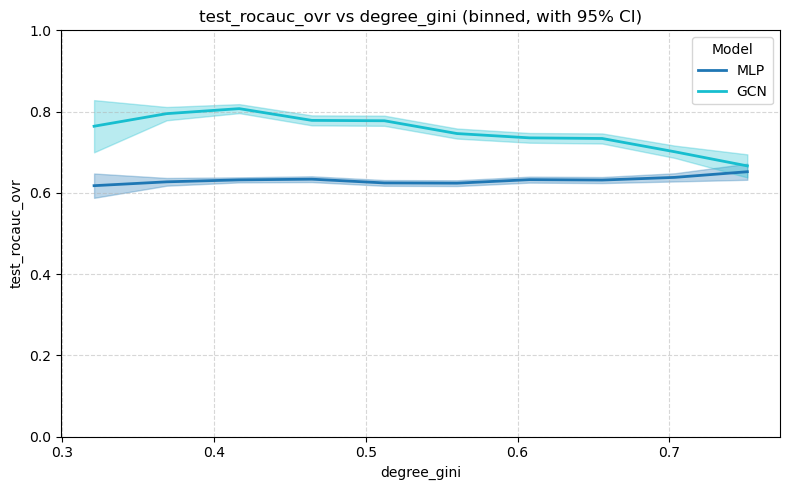

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


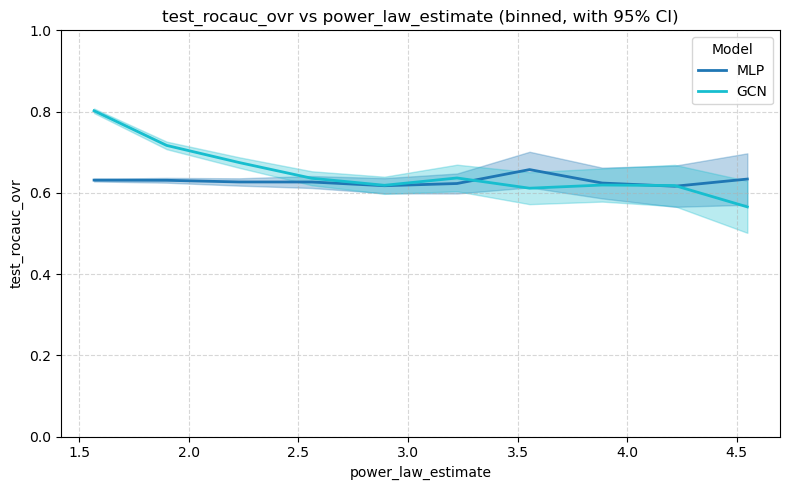

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


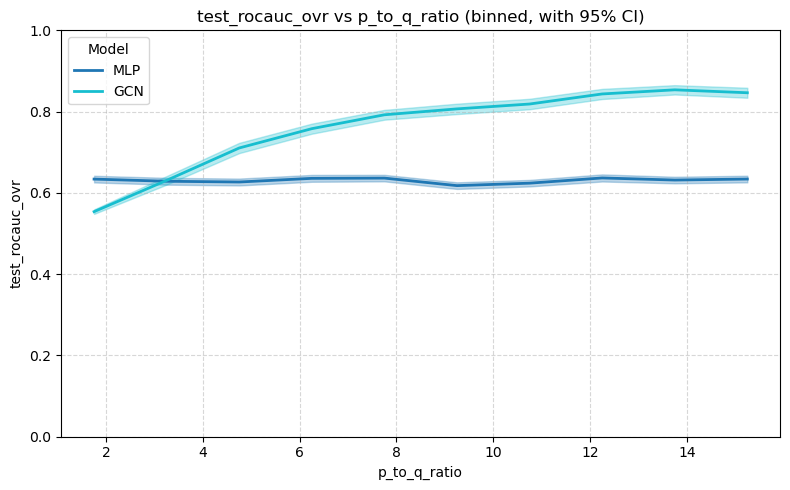

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


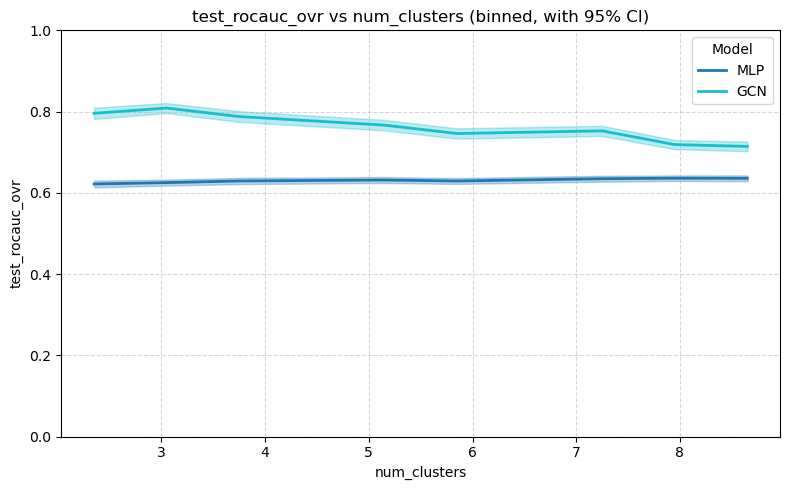

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


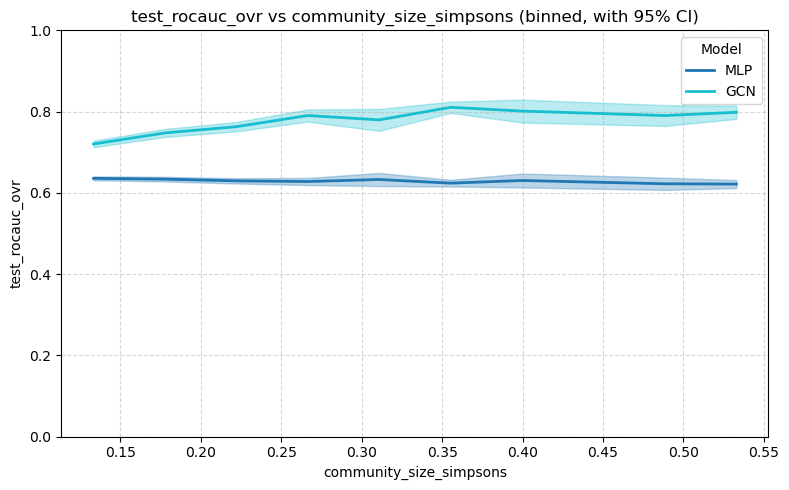

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


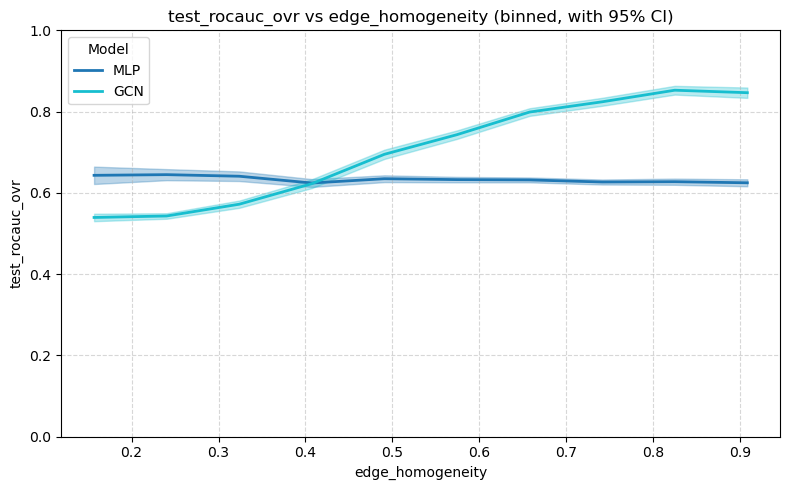

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


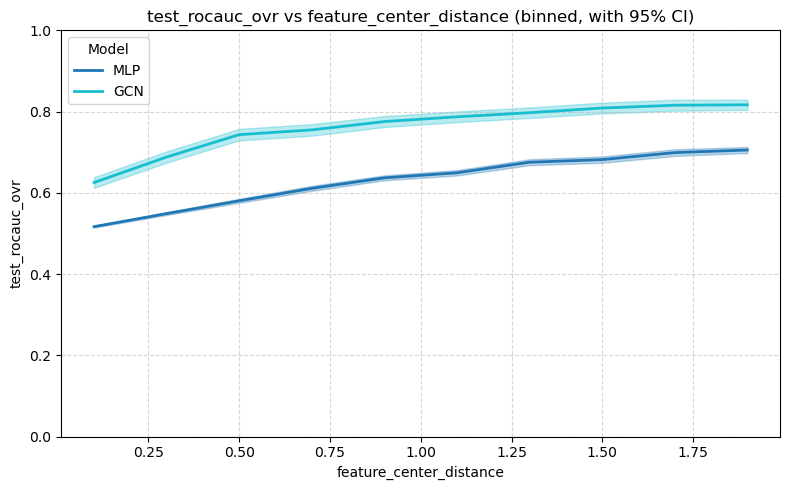

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


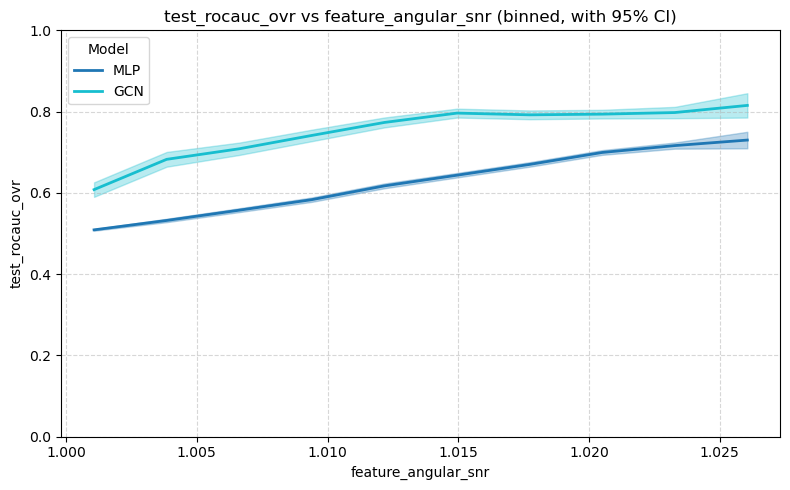

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


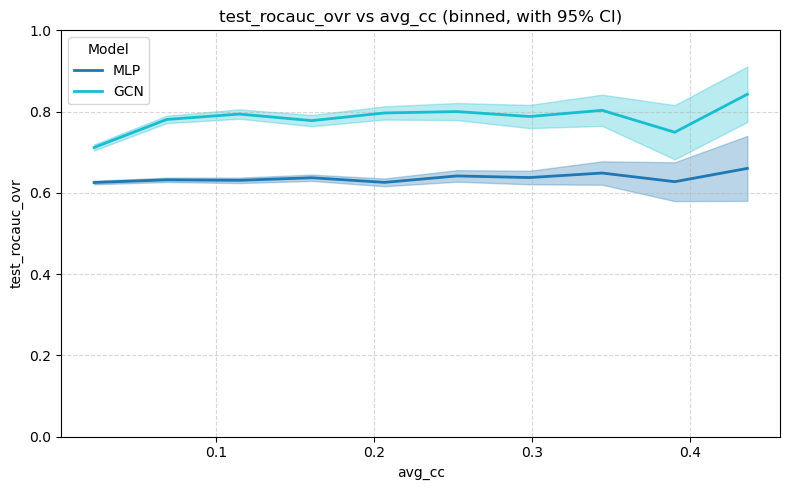

In [86]:
for m in graph_metrics_refined:
    smoothed_plot_perf_vs_metric(df, models, perf_meas, m)